In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.utils import show_prompt
from src.prompt import supervisor_decision_to_route_to_subagents
show_prompt(supervisor_decision_to_route_to_subagents, "supervisor_decision_to_route_to_subagents")

c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


╭─────────────────────────────────── supervisor_decision_to_route_to_subagents ───────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the inbound logistics Data received so far:                                                          │
│  <message>                                                                                                      │
│  {message}                                                                                                      │
│  </message>                                                                                                     │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Your role is to act as the Supervisor Agent in the Inbound Logistics system.                                   │
│  Your responsibilities are:                                                                                     │
│  1. Assess the data provided by the user.                                                                       │
│  2. Decide whether the task should be delegated to:                                                             │
│     - `logistics_agent` → if the request relates to the following fields: {logistics_fields}. **Ensure any      │
│  provided data adheres to their `dataType` and `seededValues`, if provided.**                                   │
│     - `forwarder_agent` → if the request relates to the following fields: {forwarder_fields}. **Ensure any      │
│  provided data adheres to their `dataType` and `seededValues`, if provided.**                                   │
│  3. If the request is ambiguous or missing critical details, ask the user a **clarifying question** before      │
│  assigning the task.                                                                                            │
│  4. **Do not enforce field entry yourself — instead, delegate field-specific responsibilities to the            │
│  appropriate sub-agent (`logistics_agent` or `forwarder_agent`) based on {logistics_fields} and                 │
│  {forwarder_fields}.**                                                                                          │
│                                                                                                                 │
│  Guidelines for asking clarification:                                                                           │
│  - Only ask if **absolutely necessary**.                                                                        │
│  - Keep questions **concise and structured**. Use bullet points or lists if multiple clarifications are         │
│  needed.                                                                                                        │
│  - Do not repeat questions if the information is already provided.                                              │
│                                                                                                                 │
│  Respond in **valid JSON format** with these exact keys:                                                        │
│  - `"question"` : "<clarifying question used with <delegate_to=clarify_with_user> if necessary information is   │
│  needed, otherwise empty>"                                                                                      │
│  - `"delegate_to"` : "logistics_agent" | "forwarder_agent" | "supervisor_tools" | "clarify_with_user"           │
│  - `"agent_brief"`: "<acknowledgement message confirmi

In [4]:
%%writefile ../src/supervisor_schema.py

"""Supervisor Definitions and Pydantic Schemas for Routing Workflow.

This defines the state objects and structured schemas used for Routing to 
sub agent sworkflow, including Supervisor state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain_core.tools import tool, InjectedToolArg

from pydantic import BaseModel, Field
from enum import Enum

# ===== STRUCTURED OUTPUT SCHEMAS =====

class NextAgent(str, Enum):
    END = "__end__"
    CLARIFY_WITH_USER = "clarify_with_user"
    LOGISTICS_AGENT   = "logistics_agent"
    FORWARDER_AGENT   = "forwarder_agent"
    SUPERVISOR_TOOLS  = "supervisor_tools"
    
class ClarifyWithUser(BaseModel):
    """Schema for delegation decision and questions."""
    question: str = Field(
        description = "A question to ask the user to clarify the report scope",
    )
    delegate_to: NextAgent = Field(
        description = "A decision to delegate and route the task to the next agent",
    )
    agent_brief: str = Field(
        description = "A Brief that will be used to route the task to the next sub-agent",
    )
    
class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent system.
    
    Extends MessagesState with additional fields for routing coordination.
    """
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    clarification_schemas: Optional[ClarifyWithUser] = None
    agent_brief: str

Overwriting ../src/supervisor_schema.py


In [5]:
%%writefile ../src/supervisor_agent.py

"""User Clarification and Routimg to Sub Agents.

This module implements the  the Routing workflow, where we:
1. Assess if the user's data needs clarification
2. Delegate and route to Sub Agents

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with Routing.
"""

import json
from dotenv import load_dotenv
from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage , get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.checkpoint.memory import InMemorySaver

from src.prompt import supervisor_decision_to_route_to_subagents
from src.supervisor_schema import AgentState, ClarifyWithUser, AgentInputState, NextAgent

# Load environment variables
load_dotenv()

checkpointer = InMemorySaver()

# ===== IBL FIELDS =====
try:
    with open ("../IBL_SCHEMA.json" , "r") as config_file:
        routing_fields = json.load(config_file)
except FileNotFoundError:
    print("Error: config.json not found. Please create it.")

# ===== UTILITY FUNCTIONS =====
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

# Set up tools and model binding
tools = []
tools_by_name = {tool.name: tool for tool in tools}

# Initialize model
model = init_chat_model(model="openai:gpt-4o", temperature=0.0)
model_with_tools = model.bind_tools(tools)

# ===== WORKFLOW NODES =====
def supervisor_agent(state: AgentState):
    """
        Supervisor Agent determines if the input data sufficient to make 
        deterministic decisions and assign the task to the next agent.
    """
    # Set up structured output model
    structured_output_model = model_with_tools.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=supervisor_decision_to_route_to_subagents.format(
            message=get_buffer_string(messages=state["messages"]), 
            date=get_today_str(),
            logistics_fields=routing_fields.get("logistics_agent"),
            forwarder_fields=routing_fields.get("forwarder_agent")
        ))
    ])
    
    # Route based on clarification need
    return {
             "clarification_schemas" : response ,
             "agent_brief" : response.agent_brief,
             "supervisor_messages": [
                                    AIMessage(content=response.delegate_to.value)
                                    ]
           }

def supervisor_tools(state: AgentState):
    """
        Executes all tool calls from the Supervisor Agent response.
        Returns updated state with tool execution results.
    """
    tool_calls = state["supervisor_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"supervisor_messages": tool_outputs}

def clarify_with_user(state: AgentState):
    """In Case the user needs to be asked a clarifying question."""
    clarification_schemas = state.get("clarification_schemas")
    if clarification_schemas and clarification_schemas.question:
        question = clarification_schemas.question
    return {"messages": [AIMessage(content=question)]}

def DelegateNextAgent(state: AgentState) -> Literal["logistics_agent", "forwarder_agent", "supervisor_tools", "clarify_with_user"]:
    
    """ 
        A routing logic that uses the supervisor agent's responses to determine 
        which agent should be assigned the task next 
    """

    # Then check the routing decision
    clarification_schemas = state.get("clarification_schemas")
    if not clarification_schemas:
        return "__end__"

    if clarification_schemas.delegate_to == NextAgent.LOGISTICS_AGENT:
        return "logistics_agent"
    elif clarification_schemas.delegate_to == NextAgent.FORWARDER_AGENT:
        return "forwarder_agent"
    elif clarification_schemas.delegate_to == NextAgent.CLARIFY_WITH_USER:
        return "clarify_with_user"
    else:
        return "__end__"

def logistics_agent(state: AgentState):
    pass

def forwarder_agent(state: AgentState):
    pass

# ===== GRAPH CONSTRUCTION =====

# Build the scoping workflow
supervisor_agent_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
supervisor_agent_builder.add_node("supervisor_agent"  , supervisor_agent)
supervisor_agent_builder.add_node("supervisor_tools"  , supervisor_tools)
supervisor_agent_builder.add_node("clarify_with_user" , clarify_with_user)
supervisor_agent_builder.add_node("logistics_agent"   , logistics_agent)
supervisor_agent_builder.add_node("forwarder_agent"   , forwarder_agent)

# Add workflow edges
supervisor_agent_builder.add_edge(START, "supervisor_agent")
supervisor_agent_builder.add_conditional_edges(
    "supervisor_agent",
     DelegateNextAgent,
    {
        "supervisor_tools" : "supervisor_tools"  , # execute tools,
        "clarify_with_user": "clarify_with_user" , # Provide final answer
        "logistics_agent"  : "logistics_agent" ,
        "forwarder_agent"  : "forwarder_agent"
    },
)
supervisor_agent_builder.add_edge("supervisor_tools", "supervisor_agent")
supervisor_agent_builder.add_edge("clarify_with_user", END)

# Compile the workflow
SupervisorAgent = supervisor_agent_builder.compile(checkpointer = checkpointer)

Overwriting ../src/supervisor_agent.py


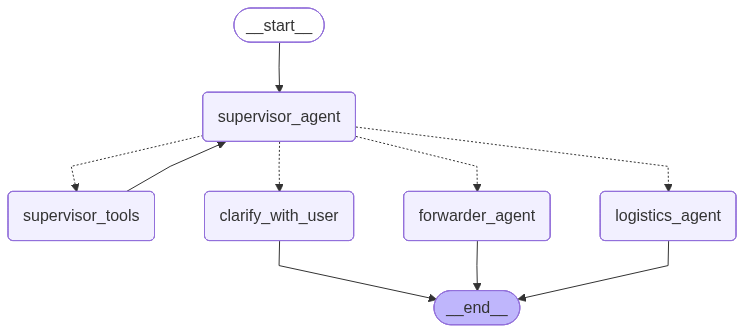

In [6]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from src.supervisor_agent import SupervisorAgent

display(Image(SupervisorAgent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
from src.supervisor_agent import SupervisorAgent
thread = {"configurable":{"thread_id":"1"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="Shipping Line: HAPAG lIOYD - HAPAG lIOYD , Shipment Readiness Date is 2025-09-30 , Pick up Date is 2025-10-30 , Port Of Destination : JISP - JEDDAH SEAPORT , ETA: 2026-07-15 , Clearing Number : 161143 , Country Of Origin : *LOCAL*")]} , config=thread)
result

{'messages': [HumanMessage(content='Shipping Line: HAPAG lIOYD - HAPAG lIOYD , Shipment Readiness Date is 2025-09-30 , Pick up Date is 2025-10-30 , Port Of Destination : JISP - JEDDAH SEAPORT , ETA: 2026-07-15 , Clearing Number : 161143 , Country Of Origin : *LOCAL*', additional_kwargs={}, response_metadata={}, id='1667f9c7-b1f0-4c40-9372-bfec4464d1cc'),
  AIMessage(content='Could you please provide the following missing details to proceed with the logistics process:\n- Division Name\n- Organization Name\n- Supplier Name\n- AWB/BL\n- Forwarder\n- Incoterm\n- Product Temperature\n- Shipment Mode', additional_kwargs={}, response_metadata={}, id='7d7bf3e3-0807-4f8e-8e26-364298510623')],
 'supervisor_messages': [AIMessage(content='clarify_with_user', additional_kwargs={}, response_metadata={}, id='b8142456-dc7c-45d5-9481-059f7bed23ab')],
 'clarification_schemas': ClarifyWithUser(question='Could you please provide the following missing details to proceed with the logistics process:\n- Divis

In [7]:
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="Well the AWB is 12345 and AWB Date 72025-08-12")]}, config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='a348447b-8c1b-4f8d-9a98-85c9f65b1ad5'),
  AIMessage(content='Please provide the AWB Date (in YYYY-MM-DD format) so we can proceed with your request.', additional_kwargs={}, response_metadata={}, id='d409d9c3-3320-44f4-a8ee-897053348acd'),
  HumanMessage(content='Well the AWB is 12345 and AWB Date 72025-08-12', additional_kwargs={}, response_metadata={}, id='d70c04bf-9d4f-4554-ac61-9c7227807426'),
  AIMessage(content="The provided AWB Date '72025-08-12' appears to be in an invalid or future format. Could you please confirm the correct AWB Date in YYYY-MM-DD format?", additional_kwargs={}, response_metadata={}, id='ed56dcf9-161e-4da2-bff3-1671e5639878')],
 'supervisor_messages': [AIMessage(content='clarify_with_user', additional_kwargs={}, response_metadata={}, id='8cbb08cd-c25f-4802-ab98-95ff8f688351'),
  AIMessage(content='clarify_with_user', additional_kwarg

In [8]:
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="Well the AWB is 12345 and AWB Date 2025-08-12")]}, config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='a348447b-8c1b-4f8d-9a98-85c9f65b1ad5'),
  AIMessage(content='Please provide the AWB Date (in YYYY-MM-DD format) so we can proceed with your request.', additional_kwargs={}, response_metadata={}, id='d409d9c3-3320-44f4-a8ee-897053348acd'),
  HumanMessage(content='Well the AWB is 12345 and AWB Date 72025-08-12', additional_kwargs={}, response_metadata={}, id='d70c04bf-9d4f-4554-ac61-9c7227807426'),
  AIMessage(content="The provided AWB Date '72025-08-12' appears to be in an invalid or future format. Could you please confirm the correct AWB Date in YYYY-MM-DD format?", additional_kwargs={}, response_metadata={}, id='ed56dcf9-161e-4da2-bff3-1671e5639878'),
  HumanMessage(content='Well the AWB is 12345 and AWB Date 2025-08-12', additional_kwargs={}, response_metadata={}, id='a16db6dc-ab90-4087-978d-ab831ecb7b76')],
 'supervisor_messages': [AIMessage(content='clari

In [9]:
thread = {"configurable":{"thread_id":"2"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="I want to enter these values AWB/BL: AWB123456, AWB/BL Date: 2025-01-15, Forwarder: DHL , Incoterm: CIF, Product Temperature: 2–8°C, Packing: Cartons, Shipping Temp: Ambient, Gel Pack Expiry Date: 2025-12-30, Handover to Clearance: 2025-01-16, Aggregation: Batch A, Notified FF Date: 2025-01-14, Green light – Date: 2025-01-13, Shipment Mode: Air, Logistic Comment: Handle with care, Remark: Priority shipment, and ASN Importation Date: 2025-01-17")]} , config=thread)
result

{'messages': [HumanMessage(content='I want to enter these values AWB/BL: AWB123456, AWB/BL Date: 2025-01-15, Forwarder: DHL , Incoterm: CIF, Product Temperature: 2–8°C, Packing: Cartons, Shipping Temp: Ambient, Gel Pack Expiry Date: 2025-12-30, Handover to Clearance: 2025-01-16, Aggregation: Batch A, Notified FF Date: 2025-01-14, Green light – Date: 2025-01-13, Shipment Mode: Air, Logistic Comment: Handle with care, Remark: Priority shipment, and ASN Importation Date: 2025-01-17', additional_kwargs={}, response_metadata={}, id='e10873e1-7917-4e46-acc3-bfc76ce84fee')],
 'supervisor_messages': [AIMessage(content='logistics_agent', additional_kwargs={}, response_metadata={}, id='f36f6269-6323-42f1-a37a-5cee2816790e')],
 'clarification_schemas': ClarifyWithUser(question='', delegate_to=<NextAgent.LOGISTICS_AGENT: 'logistics_agent'>, agent_brief="The following inbound logistics data has been provided and will be assigned to the Logistics Agent for processing:\n- AWB/BL: AWB123456\n- AWB/BL 

In [10]:
thread = {"configurable":{"thread_id":"3"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="I want to enter the AWB/BL 123457 and AWB Date, skip, yes, proceed without providing it")]} , config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB/BL 123457 and AWB Date, skip, yes, proceed without providing it', additional_kwargs={}, response_metadata={}, id='c6ccec0a-c10e-4fb4-ad4b-5681d133e46e'),
  AIMessage(content='You have provided the AWB/BL number (123457) but chose to skip the AWB/BL Date, which is a required field. Please confirm if you want to proceed without the AWB/BL Date, or would you like to provide it now?', additional_kwargs={}, response_metadata={}, id='24bddd57-6787-4ee9-9751-b0916c379381')],
 'supervisor_messages': [AIMessage(content='clarify_with_user', additional_kwargs={}, response_metadata={}, id='7bddcbe6-daef-4642-b39c-de218750b7c1')],
 'clarification_schemas': ClarifyWithUser(question='You have provided the AWB/BL number (123457) but chose to skip the AWB/BL Date, which is a required field. Please confirm if you want to proceed without the AWB/BL Date, or would you like to provide it now?', delegate_to=<NextAgent.CLARIFY_WITH_USER: 'clarify_wi

In [11]:
thread = {"configurable":{"thread_id":"3"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="I want to enter the AWB 12345 and AWB Date")]} , config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB/BL 123457 and AWB Date, skip, yes, proceed without providing it', additional_kwargs={}, response_metadata={}, id='c6ccec0a-c10e-4fb4-ad4b-5681d133e46e'),
  AIMessage(content='You have provided the AWB/BL number (123457) but chose to skip the AWB/BL Date, which is a required field. Please confirm if you want to proceed without the AWB/BL Date, or would you like to provide it now?', additional_kwargs={}, response_metadata={}, id='24bddd57-6787-4ee9-9751-b0916c379381'),
  HumanMessage(content='I want to enter the AWB 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='4a41af1c-7787-4d9f-bd63-9d401d16de70'),
  AIMessage(content='You mentioned you want to enter the AWB 12345 and AWB Date. Please provide the AWB/BL Date in YYYY-MM-DD format to proceed, as it is a required field.', additional_kwargs={}, response_metadata={}, id='978d4185-8342-4376-abc1-66d6ddbb4feb')],
 'supervisor_messages': [AIMessage(content='clar

In [12]:
thread = {"configurable":{"thread_id":"3"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="Skip")]} , config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB/BL 123457 and AWB Date, skip, yes, proceed without providing it', additional_kwargs={}, response_metadata={}, id='c6ccec0a-c10e-4fb4-ad4b-5681d133e46e'),
  AIMessage(content='You have provided the AWB/BL number (123457) but chose to skip the AWB/BL Date, which is a required field. Please confirm if you want to proceed without the AWB/BL Date, or would you like to provide it now?', additional_kwargs={}, response_metadata={}, id='24bddd57-6787-4ee9-9751-b0916c379381'),
  HumanMessage(content='I want to enter the AWB 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='4a41af1c-7787-4d9f-bd63-9d401d16de70'),
  AIMessage(content='You mentioned you want to enter the AWB 12345 and AWB Date. Please provide the AWB/BL Date in YYYY-MM-DD format to proceed, as it is a required field.', additional_kwargs={}, response_metadata={}, id='978d4185-8342-4376-abc1-66d6ddbb4feb'),
  HumanMessage(content='Skip', additional_kwargs=

In [13]:
thread = {"configurable":{"thread_id":"2"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="Yes, proceed without providing it")]} , config=thread)
result

{'messages': [HumanMessage(content='I want to enter these values AWB/BL: AWB123456, AWB/BL Date: 2025-01-15, Forwarder: DHL , Incoterm: CIF, Product Temperature: 2–8°C, Packing: Cartons, Shipping Temp: Ambient, Gel Pack Expiry Date: 2025-12-30, Handover to Clearance: 2025-01-16, Aggregation: Batch A, Notified FF Date: 2025-01-14, Green light – Date: 2025-01-13, Shipment Mode: Air, Logistic Comment: Handle with care, Remark: Priority shipment, and ASN Importation Date: 2025-01-17', additional_kwargs={}, response_metadata={}, id='f1536268-1172-465f-ae90-b972bb7868f8'),
  HumanMessage(content='I want to enter the AWB 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='b8ce965d-bf69-452c-97ce-db66f67fc67f'),
  AIMessage(content="You mentioned you want to enter 'AWB 12345 and AWB Date'. Could you please provide the AWB/BL Date for AWB 12345 (in YYYY-MM-DD format)?", additional_kwargs={}, response_metadata={}, id='8018ce8e-0d83-4130-b440-53621f6177d1'),
  HumanMessage(conten

In [ ]:
thread = {"configurable":{"thread_id":"2"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="proceed without providing")]} , config=thread)
result

{'messages': [HumanMessage(content='I want to enter these values AWB/BL: AWB123456, AWB/BL Date: 2025-01-15, Forwarder: DHL , Incoterm: CIF, Product Temperature: 2–8°C, Packing: Cartons, Shipping Temp: Ambient, Gel Pack Expiry Date: 2025-12-30, Handover to Clearance: 2025-01-16, Aggregation: Batch A, Notified FF Date: 2025-01-14, Green light – Date: 2025-01-13, Shipment Mode: Air, Logistic Comment: Handle with care, Remark: Priority shipment, and ASN Importation Date: 2025-01-17', additional_kwargs={}, response_metadata={}, id='f1536268-1172-465f-ae90-b972bb7868f8'),
  HumanMessage(content='I want to enter the AWB 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='b8ce965d-bf69-452c-97ce-db66f67fc67f'),
  AIMessage(content="You mentioned you want to enter 'AWB 12345 and AWB Date'. Could you please provide the AWB/BL Date for AWB 12345 (in YYYY-MM-DD format)?", additional_kwargs={}, response_metadata={}, id='8018ce8e-0d83-4130-b440-53621f6177d1'),
  HumanMessage(conten

In [17]:
thread = {"configurable":{"thread_id":"4"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="The shipment is scheduled to be ready on October 5th, 2025. Pick up is set for October 6th, 2025. Gross weight is 1200 KG.")]} , config=thread)
result

{'messages': [HumanMessage(content='The shipment is scheduled to be ready on October 5th, 2025. Pick up is set for October 6th, 2025. Gross weight is 1200 KG.', additional_kwargs={}, response_metadata={}, id='90639dbc-d58a-4930-91d4-3c61a321be62')],
 'supervisor_messages': [AIMessage(content='forwarder_agent', additional_kwargs={}, response_metadata={}, id='f8e2cc9d-a957-4b71-881a-a514f1c2f08e')],
 'clarification_schemas': ClarifyWithUser(question='', delegate_to=<NextAgent.FORWARDER_AGENT: 'forwarder_agent'>, agent_brief='Based on the provided details, the following data has been extracted for processing: Shipment Readiness Date: 2025-10-05, Pick Up Date: 2025-10-06, Gross weight (KG): 1200. This information pertains to the Freight Forwarder Agent and will be assigned for further handling.'),
 'agent_brief': 'Based on the provided details, the following data has been extracted for processing: Shipment Readiness Date: 2025-10-05, Pick Up Date: 2025-10-06, Gross weight (KG): 1200. This 

# Evaluation

In [6]:
from src.utils import show_prompt
from src.prompt import BRIEF_CRITERIA_PROMPT
show_prompt(BRIEF_CRITERIA_PROMPT, "BRIEF_CRITERIA_PROMPT")

╭───────────────────────────────────────────── BRIEF_CRITERIA_PROMPT ─────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are an expert evaluator for an **Inbound Logistics Supervisor Agent**. Your task is to assess whether the  │
│  agent's output (either an 'agent_brief' or a 'question') **accurately captures a specific user requirement or  │
│  extracted data point.**                                                                                        │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the agent's output adequately captures the specific success criterion provided. Return a binary   │
│  assessment with detailed reasoning.                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  The Supervisor Agent's output is **critical for downstream sub-agents** (`logistics_agent`,                    │
│  `forwarder_agent`) to execute tasks. Missing data or an inadequate question will lead to system failure or     │
│  incorrect processing. **Accurate evaluation ensures system reliability.**                                      │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <criterion_to_evaluate>                                                                                        │
│  {criterion}                                                                                                    │
│  </criterion_to_evaluate>                                                                                       │
│                                                                                                                 │
│  <agent_output>                                                                                                 │
│  {agent_output}                                                                                                 │
│  </agent_output>                                                                                                │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  CAPTURED (criterion is adequately represented) if:                                                             │
│  - The agent's output **explicitly mentions or directly addresses** the criterion.                              │
│  - The output contains **equivalent data values** (e.g., date formats changed but correct).                     │
│  - The criterion's **intent is preserved** (e.g., a critical detail is routed to the correct agent).            │
│  - All key aspects of the criterion are represented.                                                            │
│                                                       

In [7]:
from src.prompt import BRIEF_HALLUCINATION_PROMPT
show_prompt(BRIEF_HALLUCINATION_PROMPT, "BRIEF_HALLUCINATION_PROMPT")

╭────────────────────────────────────────── BRIEF_HALLUCINATION_PROMPT ───────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are a meticulous **Inbound Logistics Supervisor Agent Auditor** specializing in identifying **unwarranted  │
│  assumptions** in the agent's output.                                                                           │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the agent's brief introduces specific **detail values** (such as dates, numbers, codes, or        │
│  weights) that were **NOT** explicitly provided by the user in the original message. Return a binary pass/fail  │
│  judgment.                                                                                                      │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  The `agent_brief` must only contain data that the user has provided. Inventing specific detail values          │
│  (hallucinations) leads to corrupted data entry and operational failure in downstream systems.                  │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <user_input>                                                                                                   │
│  {user_input}                                                                                                   │
│  </user_input>                                                                                                  │
│                                                                                                                 │
│  <agent_brief>                                                                                                  │
│  {agent_brief}                                                                                                  │
│  </agent_brief>                                                                                                 │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  PASS (no unwarranted detail values) if:                                                                        │
│  - The brief only contains detail values (dates, numbers, codes, weights, etc.) **directly traceable** to the   │
│  user input.                                                                                                    │
│  - Information related to delegation decisions, logical interpretations, or summaries of user action (**e.g.,   │
│  'confirmed', 'skipped fields', 'assigned to logistics_agent'**) are present but are **NOT** considered         │
│  hallucinations.                                                                                                │
│                                                       

In [8]:
from langsmith import Client
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from typing import List
from pydantic import BaseModel, Field

langsmith_client = Client()
dataset_name = "supervisor_agent_evaluation"

# Clean up previous dataset if it exists
if langsmith_client.has_dataset(dataset_name = dataset_name):
    langsmith_client.delete_dataset(dataset_name = dataset_name)

# Define different scenarios with their criteria
test_scenarios = [
    (
        {"message": "Please process this new Air shipment. The AWB/BL number is 157-98765432 and its date is 2025-09-28."},
        {
            "delegate_to": "logistics_agent",
            "criteria": [
                "Brief contains the AWB/BL number '157-98765432'",
                "Brief contains the AWB date '2025-09-28'",
                "Brief mentions the shipment mode is 'Air'",
            ]
        }
    ),
    
    (
        {"message": "The shipment is scheduled to be ready on October 5th, 2025. Pick up is set for October 6th, 2025. Gross weight is 1200 KG."},
        {
            "delegate_to": "forwarder_agent",
            "criteria": [
                "Brief contains the Shipment Readiness Date 'October 5th, 2025' or '2025-10-05'",
                "Brief contains the Pick Up Date 'October 6th, 2025' or '2025-10-06'",
                "Brief contains the Gross Weight '1200 KG'",
            ]
        }
    ),

    (
        {"message": "New Shipment: AWB/BL is 888-11122233, and the Pick Up date is tomorrow"},
        {
            "delegate_to": "clarify_with_user",
            "criteria": [
                "Asks a question that requests informatiom from which it can determine if the task is for logistics or forwarder: such as AWB date, Pickup date, or Readiness date",
                "Does not generate an agent brief",
            ]
        }
    ),

    (
        {"message": "The AWB/BL for the new shipment is 456-78901234 with Air mode and date 2025-02-05. What is the ASN Importation Date?"},
        {
            "delegate_to": "logistics_agent",
            "criteria": [
                          "Brief contains the AWB/BL number '456-78901234'",
                          "Brief contains the shipment mode 'air'",
                          "Brief contains the AWB date '2025-02-05'",
                          "Brief contains the user's direct question: 'What is the ASN Importation Date?'",
            ]
        }
    ),

    (
        {"message": "Can you tell me a joke?"},
        {
            "delegate_to": "clarify_with_user",
            "criteria": [
                        "Identify that the question 'Can you tell me a joke?' is irrelevant to the logistics context.",
                        "you MUST prompt the user to provide logistics or forwarder related information.",
                        "Do not generate an agent brief for irrelevant questions."
                    ]
        }
    ),
]

# Dataset creation
dataset = langsmith_client.create_dataset(
    dataset_name = dataset_name,
    description = "Test cases for the supervisor agent's routing and output quality.",
)

# Create examples in the dataset
for inputs, outputs in test_scenarios:
    langsmith_client.create_example(inputs = inputs, outputs = outputs, dataset_id = dataset.id)

## Routing Sucess Evalution

In [9]:
# === Evaluator 1: Routing Sucess Evalution  ===
def evaluate_routing_success(run, example):
    prediction = run.outputs or {}
    expected_delegate_to = example.outputs.get('delegate_to')
    
    if not prediction or 'delegate_to' not in prediction:
        return {"key": "routing_success", "score": 0}
    
    is_correct = prediction['delegate_to'] == expected_delegate_to

    return {
             "key"   : "routing_success",
             "score" : 1 if is_correct else 0,
          }

## Brief Quality Check (LLM as a Judge)

In [10]:
# Pydantic responses for llm-as-a-judge
class LLMJudgeResponse(BaseModel):
    is_captured: bool = Field(description = "Whether this specific criteria is adequately captured in the agent output (True) or missing/inadequately addressed (False)")
    reasoning: str = Field(description = "Detailed explanation of why this criteria is or isn't captured in the agent output, including specific evidence from the brief/question")

class CriterionResult(LLMJudgeResponse):
    criteria_text: str = Field(description = "The specific success criteria being evaluated (e.g., 'AWB is 123456', 'AWB Date is October 5th, 2025')")

# === Evaluator 2: Brief Quality (LLM as a Judge) ===
def evaluate_success_criteria(run, example):
    prediction = run.outputs or {}
    criteria: List[str] = example.outputs.get('criteria', [])
    
    if not criteria:
        return {"key": "brief_quality", "score": 1, "comment": "No criteria to evaluate."}

    agent_output_text = "\n".join([
                                   f"Agent Brief   : {prediction.get('agent_brief', '')}",
                                   f"Question      : {prediction.get('question', '')}",
                                   f"Delegate To   : {prediction.get('delegate_to', '')}"
                                ])
    
    model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
    structured_output_model = model.with_structured_output(LLMJudgeResponse)
    
    prompts = [
                [HumanMessage(content = BRIEF_CRITERIA_PROMPT.format(criterion = c, agent_output = agent_output_text))] for c in criteria
            ]
    
    try:
        responses = structured_output_model.batch(prompts)
    except Exception as e:
        return {"key": "brief_quality", "score": 0, "comment": f"LLM judge failed with error: {e}"}

    individual_evaluations = [
                                CriterionResult(
                                                criteria_text = criterion,
                                                is_captured   = response.is_captured,
                                                reasoning     = response.reasoning
                                            )  for criterion, response in zip(criteria, responses)
                        ]
    
    captured_count = sum(1 for res in individual_evaluations if res.is_captured)
    score = captured_count / len(criteria)
    
    return {
            "key"     : "brief_quality",
            "score"   : score          ,
            "comment" : f"Captured {captured_count}/{len(criteria)} criteria.",
            "individual_evaluations" : [res.model_dump() for res in individual_evaluations]
          }

## Hallucination Check (LLM as a Judge)

In [11]:
# Pydantic responses for llm-as-a-judge
class NoHallucinations(BaseModel):
    no_hallucinations: bool = Field(description = "Whether the agent brief avoids making unwarranted assumptions. True if the brief only includes information explicitly provided by the user, False if it makes assumptions beyond what was stated.")
    reasoning: str = Field(description = "Detailed explanation of the evaluation decision, including specific examples of any assumptions found or confirmation that no assumptions were made beyond the user's explicit statements.")

# === Evaluator 3: Hallucination Check (LLM Judge) ===
def evaluate_Nohallucinations(run, example):
    prediction = run.outputs or {}
    user_input = example.inputs.get('message', '')
    
# Skip hallucination check if delegate_to is "clarify_with_user"
    if prediction.get('delegate_to') == 'clarify_with_user':
        return {
                "key"     : "hallucination_check",
                "score"   : 1 ,
                "comment" : "Skipped: No agent_brief for clarify_with_user"
            }
    
    agent_brief = prediction.get('agent_brief', '')
    
    # Skip if no brief available
    if not agent_brief or agent_brief == "NOT AVAILABLE":
        return {
                "key"     : "hallucination_check",
                "score"   : 1,
                "comment" : "Skipped: No agent_brief available"
            }

    model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
    structured_output_model = model.with_structured_output(NoHallucinations)
    
    prompt = [
              HumanMessage(content = BRIEF_HALLUCINATION_PROMPT.format(
                                                                        user_input = user_input  ,
                                                                        agent_brief = agent_brief
                                                                     )
                        )
           ]
    
    try:
        response = structured_output_model.invoke(prompt)
    except Exception as e:
         return {"key": "hallucination_check", "score": 0, "comment": f"LLM as a Judge failed with error: {e}"}

    return {
            "key"     : "hallucination_check",
            "score"   : 1 if response.no_hallucinations else 0,
            "comment" : response.reasoning
        }

In [12]:
import uuid
from langsmith.evaluation import evaluate
from src.supervisor_agent import SupervisorAgent

# === Agent Target Function ===
def target_agent(inputs: dict):
    
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    graph_output = SupervisorAgent.invoke(
                                          {"messages" : [HumanMessage(content = inputs["message"])]} , config = config
                                        )
    
    clarification_schema = graph_output.get('clarification_schemas')
    agent_brief          = graph_output.get('agent_brief', '')
    question             = clarification_schema.question
    
    if not clarification_schema:
        return {
                "delegate_to" : "ERROR",
                "agent_brief" : "",
                "question"    : "Agent did not respond with an appropriate clarification_schemas.",
            }

    if agent_brief == "":
        agent_brief = "NOT AVAILABLE"
    if question == "":
        question = "NOT AVAILABLE"

    return {
             "delegate_to" : clarification_schema.delegate_to.value,
             "agent_brief" : agent_brief,
             "question"    : question,
          }

# The rest of your script remains the same
evaluate(
         target_agent ,
         data = "supervisor_agent_evaluation" ,
         evaluators = [
                        evaluate_routing_success    ,
                        evaluate_success_criteria   ,
                        evaluate_Nohallucinations   ,
                ] ,
         experiment_prefix = "supervisor-agent-eval",
    )

print("✅ Evaluation complete. Check your LangSmith project for detailed results.")

View the evaluation results for experiment: 'supervisor-agent-eval-41b0727c' at:
https://smith.langchain.com/o/0e777694-d414-4358-b3c7-8f0d470d12e7/datasets/c3f1285c-1fe5-48de-b599-abb7a07279d7/compare?selectedSessions=a21f50da-158d-40f7-9f7a-936d39d2e7bc




5it [00:34,  6.94s/it]

✅ Evaluation complete. Check your LangSmith project for detailed results.
